In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import sklearn
from skimage import measure, filters
from matplotlib import cm
from sklearn.cluster import SpectralClustering
from scipy import signal
import skimage.measure
from random import random
from numpy import linalg
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import random_walker
from scipy import ndimage
from scipy.stats import norm

In [2]:
class EllipsoidTool:
    """Some stuff for playing with ellipsoids"""
    def __init__(self): pass
    
    def getMinVolEllipse(self, P=None, tolerance=0.01):
        """ Find the minimum volume ellipsoid which holds all the points
        
        Based on work by Nima Moshtagh
        http://www.mathworks.com/matlabcentral/fileexchange/9542
        and also by looking at:
        http://cctbx.sourceforge.net/current/python/scitbx.math.minimum_covering_ellipsoid.html
        Which is based on the first reference anyway!
        
        Here, P is a numpy array of N dimensional points like this:
        P = [[x,y,z,...], <-- one point per line
             [x,y,z,...],
             [x,y,z,...]]
        
        Returns:
        (center, radii, rotation)
        
        """
        (N, d) = np.shape(P)
        d = float(d)
    
        # Q will be our working array
        Q = np.vstack([np.copy(P.T), np.ones(N)]) 
        QT = Q.T
        
        # initializations
        err = 1.0 + tolerance
        u = (1.0 / N) * np.ones(N)

        # Khachiyan Algorithm
        while err > tolerance:
            V = np.dot(Q, np.dot(np.diag(u), QT))
            M = np.diag(np.dot(QT , np.dot(linalg.inv(V), Q)))    # M the diagonal vector of an NxN matrix
            j = np.argmax(M)
            maximum = M[j]
            step_size = (maximum - d - 1.0) / ((d + 1.0) * (maximum - 1.0))
            new_u = (1.0 - step_size) * u
            new_u[j] += step_size
            err = np.linalg.norm(new_u - u)
            u = new_u

        # center of the ellipse 
        center = np.dot(P.T, u)
    
        # the A matrix for the ellipse
        A = linalg.inv(
                       np.dot(P.T, np.dot(np.diag(u), P)) - 
                       np.array([[a * b for b in center] for a in center])
                       ) / d
                       
        # Get the values we'd like to return
        U, s, rotation = linalg.svd(A)
        radii = 1.0/np.sqrt(s)        
        return (center, radii, rotation)

    def getEllipsoidVolume(self, radii):
        """Calculate the volume of the blob"""
        return 4./3.*np.pi*radii[0]*radii[1]*radii[2]

def plotellipse(ax,center,radii,rotmat,density=100,color='r'):
    tgrid = np.linspace(0,2*np.pi,density)
    Rx,Ry = radii[0],radii[1]

    xgrid = Rx*np.cos(tgrid)
    ygrid = Ry*np.sin(tgrid)
    
    tmp = np.asarray([xgrid,ygrid])
    coords = np.dot(rotmat,tmp)
    ax.plot(coords[0]+center[0],coords[1]+center[1],c=color)
    return coords[0]+center[0],coords[1]+center[1]


In [3]:
def normalize(mat,scale=1):
    if scale == 1:
        return (mat - np.min(mat)) /np.max(mat - np.min(mat))
    if scale == 255:
        return ((255*(mat - np.min(mat))) /np.max(mat - np.min(mat))).astype('uint8')
    else:
        print("UNKWNOW")
        return np.nan
def bindown(diff):
    m,n = diff.shape
    m_bins=int(m/8)
    n_bins=int(n/8)
    print(m_bins,n_bins)
    nimg = diff.reshape(m_bins, m // m_bins, n_bins, n // n_bins).sum(3).sum(1)

    nimg = nimg/np.max(nimg)
    return nimg

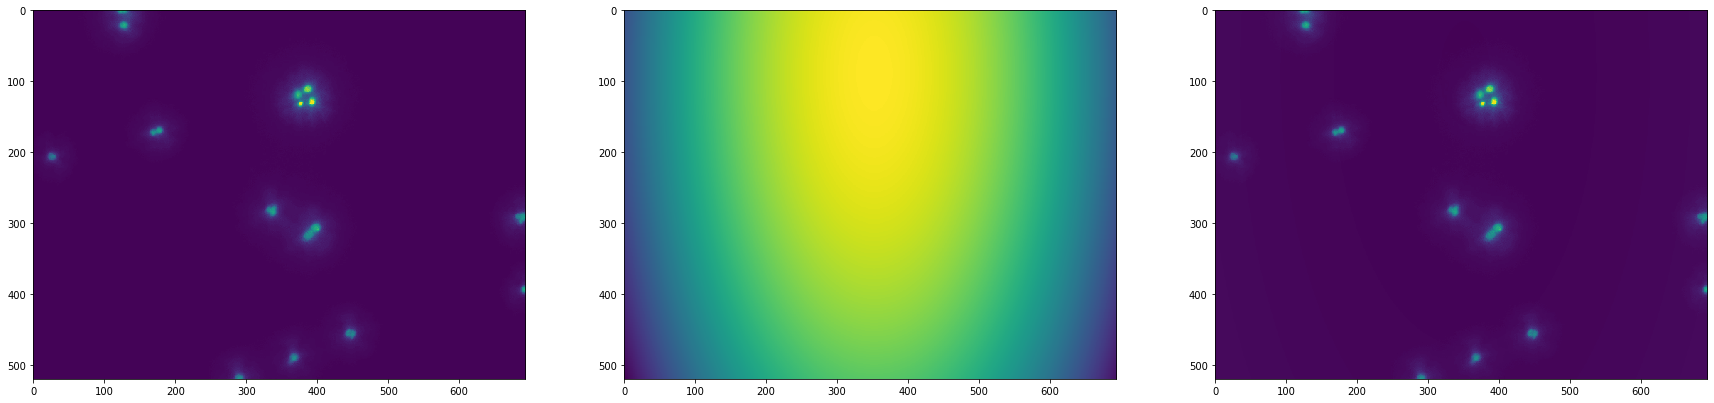

In [48]:
img = cv2.imread('ezpz_af.jpeg',0) # Read in B&W

img = cv2.resize(img, dsize=(694,520), interpolation=cv2.INTER_CUBIC)
#Fit background
#adaped from https://stackoverflow.com/questions/33964913/equivalent-of-polyfit-for-a-2d-polynomial-in-python
ymax,xmax = img.shape
xs = np.arange(0,xmax,1)
ys = np.arange(0,ymax,1)
X, Y = np.meshgrid(xs, ys, copy=False)
Z = img

Xn = X.flatten()
Yn = Y.flatten()
A = np.array([Xn*0+1, Xn, Yn,Xn**2,Yn**2]).T
B = Z.flatten()

coeff, r, rank, s = np.linalg.lstsq(A, B,rcond=None)
res = coeff[0]+coeff[1]*X+coeff[2]*Y+coeff[3]*X**2+coeff[4]*Y**2


nimg = normalize(img-res,255)


fig,ax = plt.subplots(ncols=3,figsize=(30,10))
ax[0].imshow(img)
ax[1].imshow(res)
ax[2].imshow(nimg)

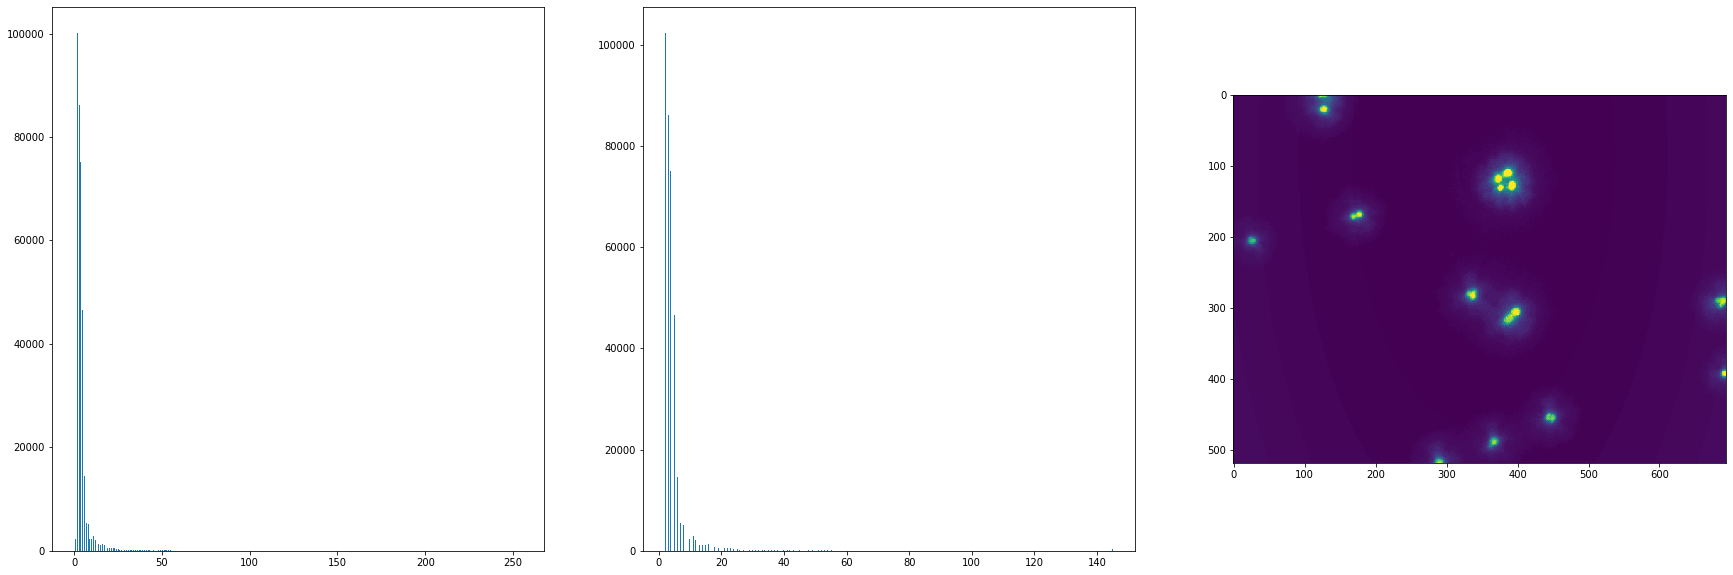

In [49]:
mimg = np.copy(nimg)

#percentile clip the result
low = 1
high = 99.9
nimg[np.where(nimg < np.percentile(nimg,low))] = np.percentile(nimg,low)
nimg[np.where(nimg > np.percentile(nimg,high))] = np.percentile(nimg,high)

fig,ax = plt.subplots(ncols=3,figsize=(30,10))
ax[0].hist(mimg.flatten(),bins=500)
ax[1].hist(nimg.flatten(),bins=500)
ax[2].imshow(nimg)
plt.show()

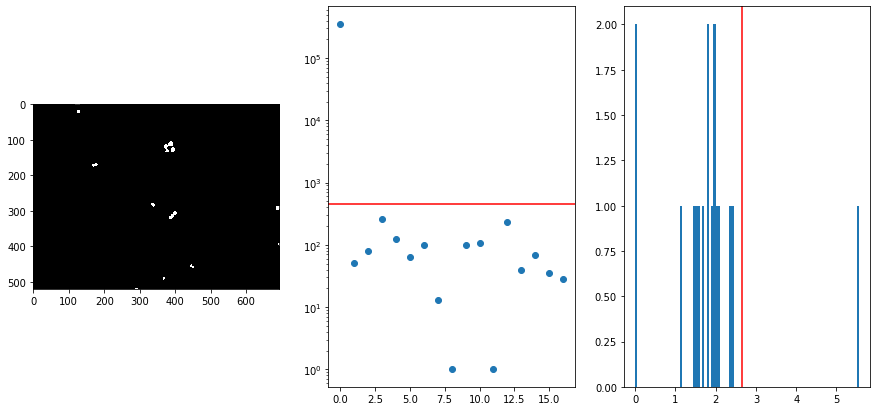

In [65]:
thresh = 450

#out1 = cv2.adaptiveThreshold(nimg,120,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3)
ret,out1 = cv2.threshold(nimg,100,255,cv2.THRESH_BINARY)
#out1 = cv2.adaptiveThreshold(nimg,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
#subset = out1[:548,:548]
subset = out1[:,:]

#hole filling method
all_labels = measure.label(subset,connectivity=1)
unique_lables = list(set(all_labels.flatten()))
areas = []
#find background
for label in unique_lables:
    areas.append(len(np.where(all_labels==label)[0]))

biggest = np.sort(areas)[-1]
biggest2 = np.sort(areas)[-2]
big_label = unique_lables[np.where(biggest==areas)[0][0]]
big_label2 = unique_lables[np.where(biggest2==areas)[0][0]]
unclassified_sizes = np.asarray(areas)[unique_lables]

fig,ax = plt.subplots(ncols=3,figsize=(15,7))
ax[0].imshow(out1,'gray')
ax[1].scatter(unique_lables,areas)
ax[1].axhline(thresh,c='r')
ax[1].set_yscale('log')
ax[2].hist(np.log10(areas),bins=100)
ax[2].axvline(np.log10(thresh),c='r')
plt.show()

In [66]:
biglocs=np.where(all_labels==big_label)
big2locs=np.where(all_labels==big_label2)

all_labels[biglocs] = 0
all_labels[big2locs] = 255

unique_lables.remove(big_label)
unique_lables.remove(big_label2)
for label in unique_lables:
    if areas[label] <= thresh:
        all_labels[np.where(all_labels== label)] = 255
    else:
        all_labels[np.where(all_labels== label)] = 0
        
filled = all_labels/255

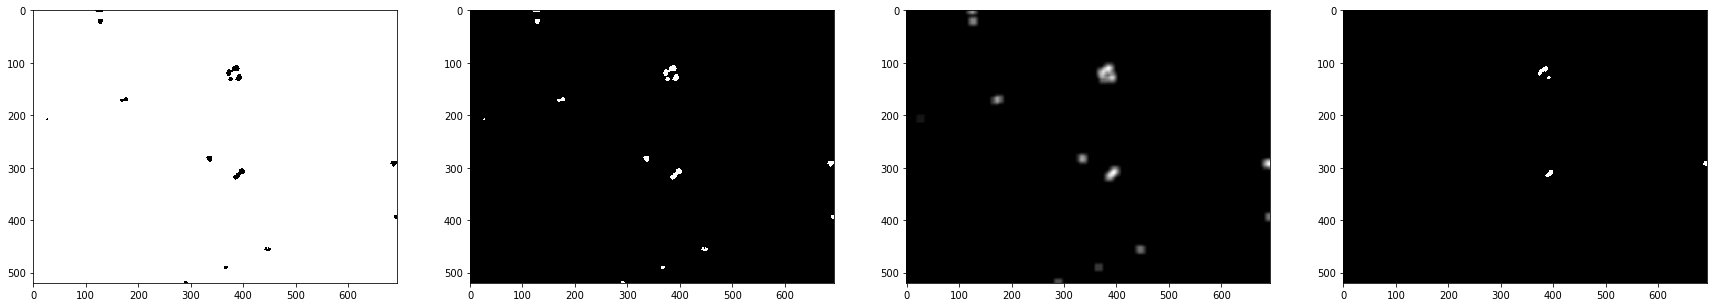

In [67]:
# blur the filled
blured = cv2.blur(filled,(15,15))
thresh_blur = np.copy(blured)
thresh_blur[np.where(thresh_blur>0.5)] = 1
thresh_blur[np.where(thresh_blur<=0.5)] = 0

fig,ax = plt.subplots(ncols=4,figsize=(30,10))
ax[0].imshow(255-subset,'gray')
ax[1].imshow(filled,'gray')
ax[2].imshow(blured,'gray')
ax[3].imshow(thresh_blur,'gray')

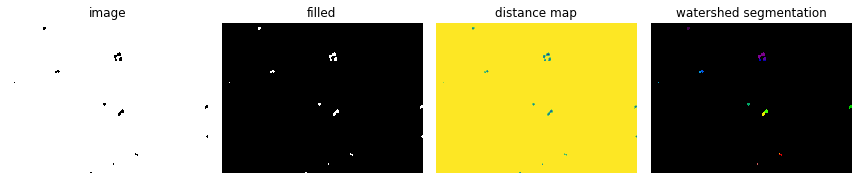

In [68]:
image = filled


distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = measure.label(local_maxi)

blur_dist =  cv2.blur(distance,(15,15))

labels_ws = watershed(-distance, markers, mask=image)
labels_ws_blur = watershed(-blur_dist, markers, mask=image)

plt.figure(figsize=(15, 5))
plt.subplot(151)
plt.imshow(255-subset, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('image')
plt.subplot(152)
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('filled')
plt.subplot(153)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.title('distance map')
plt.subplot(154)
plt.imshow(labels_ws, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.title('watershed segmentation')
plt.tight_layout()
plt.show()

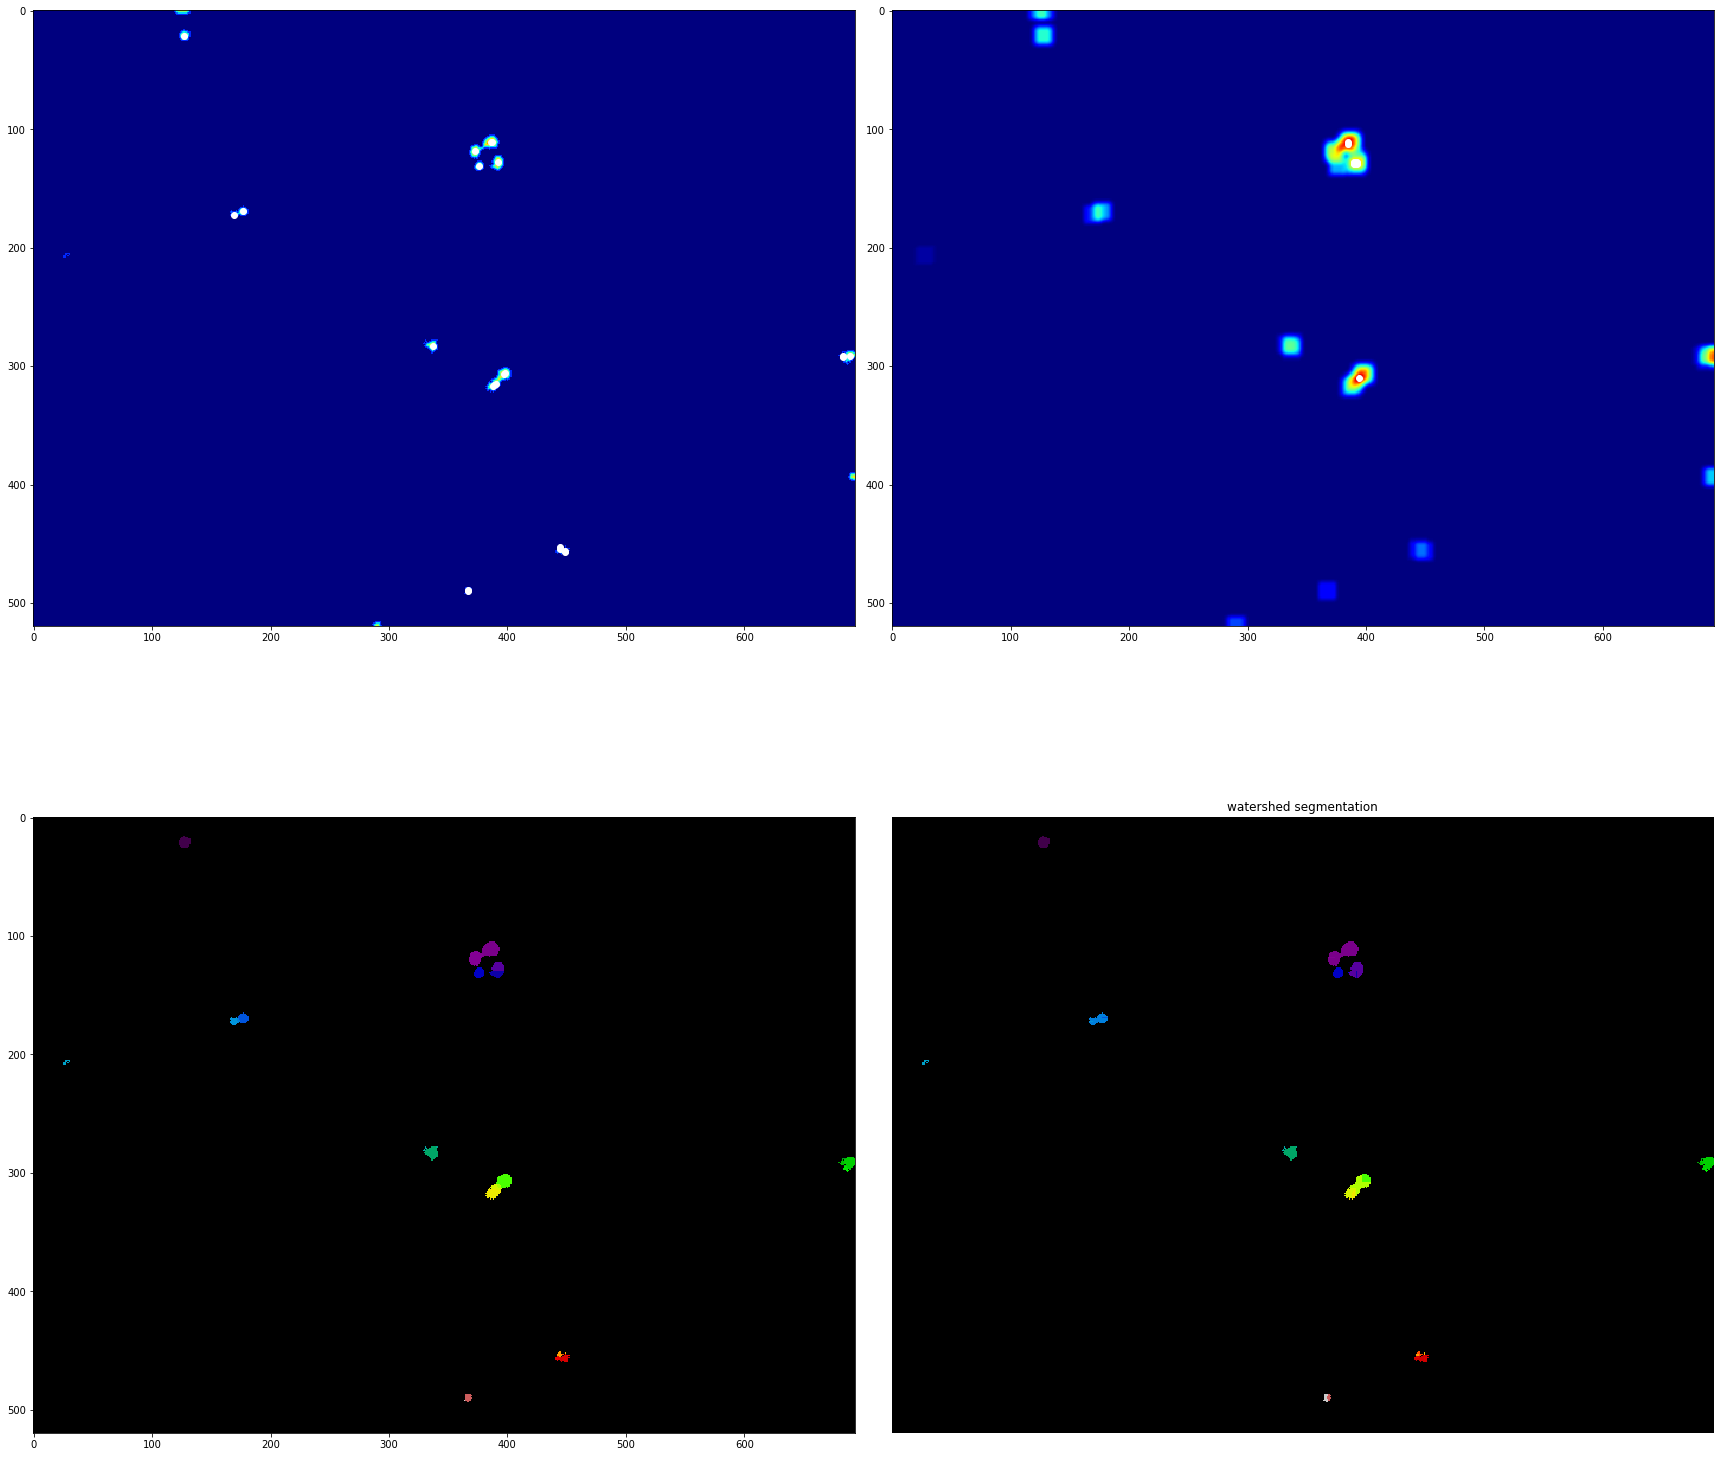

In [69]:
fig,ax = plt.subplots(ncols=2,nrows=2, figsize=(24, 24))
ax[0,0].imshow(distance,cmap='jet')
xy = peak_local_max(distance, min_distance=2,threshold_abs=1)
ax[0,0].scatter(xy[:,1],xy[:,0],c='w')
ax[1,0].imshow(labels_ws, cmap='nipy_spectral', interpolation='none')



ax[0,1].imshow(blur_dist,cmap='jet')
xy = peak_local_max(blur_dist, min_distance=2,threshold_abs=1)
ax[0,1].scatter(xy[:,1],xy[:,0],c='w')
ax[1,1].imshow(labels_ws_blur, cmap='nipy_spectral', interpolation='none')
plt.axis('off')
plt.title('watershed segmentation')
plt.tight_layout()
plt.show()

This actually works pretty well. Try adding a gaussian blur to reduce the noise?

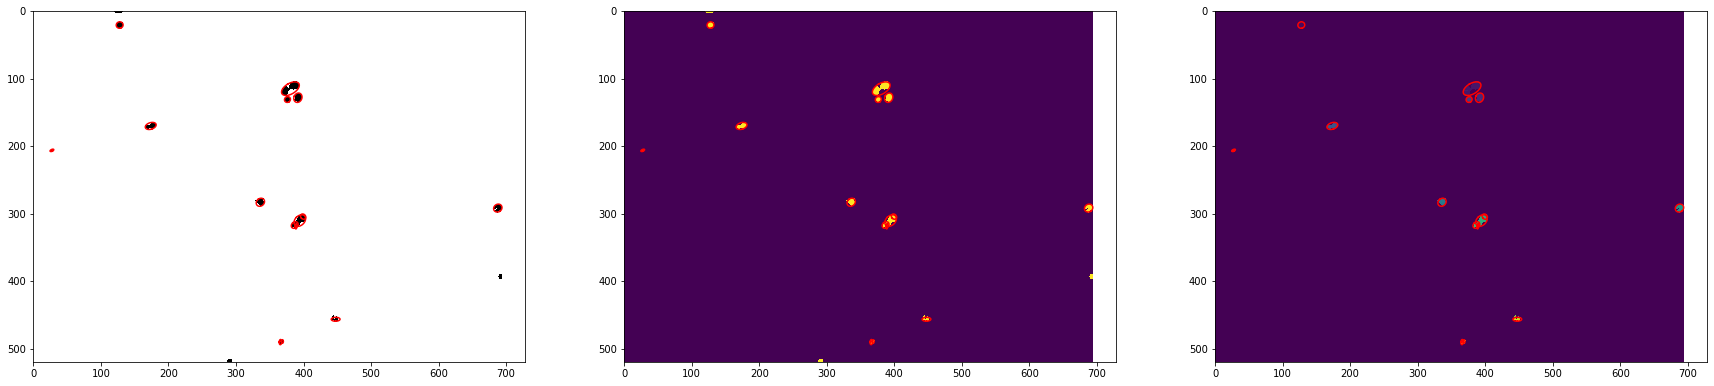

In [81]:
centers = []
radiis = []
rotations = []
ellip_coords = []


fig,ax = plt.subplots(ncols=3,figsize=(30,10))
ax[0].imshow(255-subset, cmap='gray', interpolation='nearest')
ax[1].imshow(image)
ax[2].imshow(labels_ws_blur)

lower = 10
upper = 2500
labels = list(set(labels_ws_blur.flatten()))
for label in labels:
    P = np.asarray(np.where(labels_ws_blur==label)).T
    P = np.fliplr(P)
    if lower < len(P) < upper:
        # find the ellipsoid
        (center, radii, rotation) = EllipsoidTool().getMinVolEllipse(P, 1e-2)
        centers.append(center)
        radiis.append(radii)
        rotations.append(rotation)
        # plot points
        res = plotellipse(ax[0],center,radii,rotation)
        ellip_coords.append(res)
        plotellipse(ax[1],center,radii,rotation)
        plotellipse(ax[2],center,radii,rotation)

In [82]:
centers=np.asarray(centers)
radiis=np.asarray(radiis)
rotations=np.asarray(rotations)
ellip_coords=np.asarray(ellip_coords)

In [83]:
from scipy.spatial import ConvexHull

#slow and stupid. 
def inhull(points, p):
    hull = ConvexHull(points)
    new_points = np.append(points, p, axis=0)
    new_hull = ConvexHull(new_points)
    if list(hull.vertices) == list(new_hull.vertices):
        return True
    else:
        return False

In [84]:
def numerical_area(ellip_coords,imgshape):
    xtest,ytest = ellip_coords
    topx = np.ceil(np.max(xtest))
    botx = np.floor(np.min(xtest))
    topy = np.ceil(np.max(ytest))
    boty = np.floor(np.min(ytest))
    
    xgrid = np.arange(botx,topx+1,1).astype(int)
    ygrid = np.arange(boty,topy+1,1).astype(int)

    plist = []
    for x in xgrid:
        for y in ygrid:
            if 0 < y < imgshape[0] and 0 < x <= imgshape[1]:
                plist.append([x,y])

    plist=np.asarray(plist)
    points = np.asarray([xtest,ytest]).T
    
    interior = []
    for p in plist:
        interior.append(inhull(points,[p]))
    interior = np.asarray(interior).astype(int)
    return np.sum(interior)

In [85]:
a = radiis[:,1]
b = radiis[:,0]
eccs = np.sqrt(1-(b**2)/(a**2))
areas = np.pi*a*b

nareas = []
for ellip_coord in ellip_coords:
    nareas.append(numerical_area(ellip_coord,img.shape))
gof = (nareas - areas)/areas

## Lets check out the results!

In [86]:
edge_thresh = 35
good_points = np.where((edge_thresh <centers[:,0])& (centers[:,0]<img.shape[1]-edge_thresh)&(edge_thresh<centers[:,1])&(centers[:,1]<img.shape[0]-edge_thresh))
bad_points = []
colors = []
for i in range(len(centers)):
    if i in good_points[0]:
        colors.append('b')
    else:
        colors.append('r')
        bad_points.append(i)

(array([1., 1., 2., 1., 2., 0., 1., 1., 4., 2.]),
 array([0.32984683, 0.38998313, 0.45011943, 0.51025573, 0.57039202,
        0.63052832, 0.69066462, 0.75080092, 0.81093721, 0.87107351,
        0.93120981]),
 <a list of 10 Patch objects>)

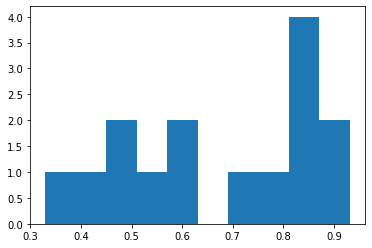

In [87]:
plt.hist(b/a)

Text(0.5, 0, 'log10(|gof|)')

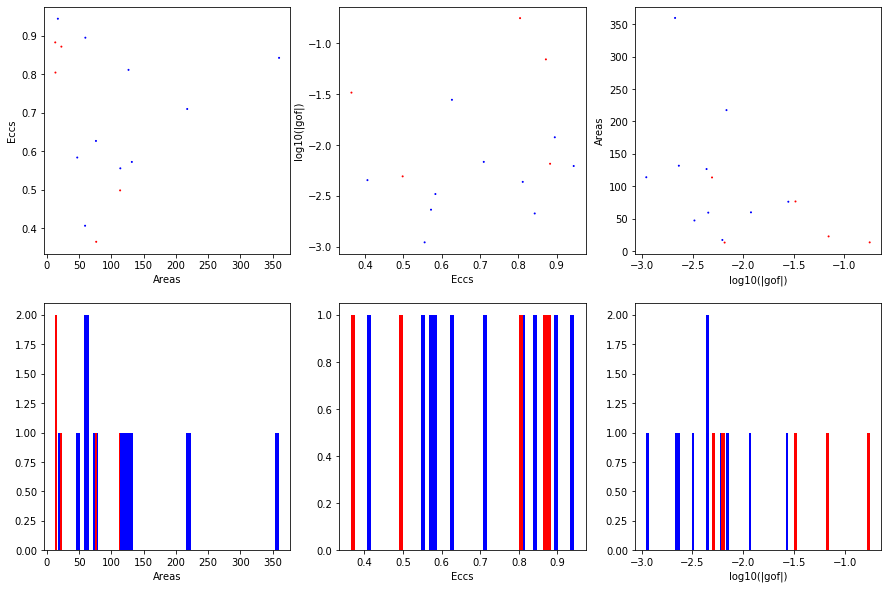

In [88]:
bnum = 50
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,10))
ax[0,0].scatter(areas,eccs,s=1,c=colors)
ax[0,1].scatter(eccs,np.log10(np.abs(gof)),s=1,c=colors)
ax[0,2].scatter(np.log10(np.abs(gof)),areas,s=1,c=colors)

ax[1,0].hist(areas[good_points],bins=bnum,color='b')
ax[1,0].hist(areas[bad_points],bins=bnum,color='r')
ax[1,1].hist(eccs[good_points],bins=bnum,color='b')
ax[1,1].hist(eccs[bad_points],bins=bnum,color='r')
ax[1,2].hist(np.log10(np.abs(gof))[good_points],bins=bnum,color='b')
ax[1,2].hist(np.log10(np.abs(gof))[bad_points],bins=bnum,color='r')


ax[0,0].set_xlabel("Areas")
ax[0,0].set_ylabel("Eccs")
ax[0,1].set_xlabel("Eccs")
ax[0,1].set_ylabel("log10(|gof|)")
ax[0,2].set_xlabel("log10(|gof|)")
ax[0,2].set_ylabel("Areas")

ax[1,0].set_xlabel("Areas")
ax[1,1].set_xlabel("Eccs")
ax[1,2].set_xlabel("log10(|gof|)")

In [89]:
nareas = areas[good_points]
neccs = eccs[good_points]
ngof = np.log10(np.abs(gof))[good_points]

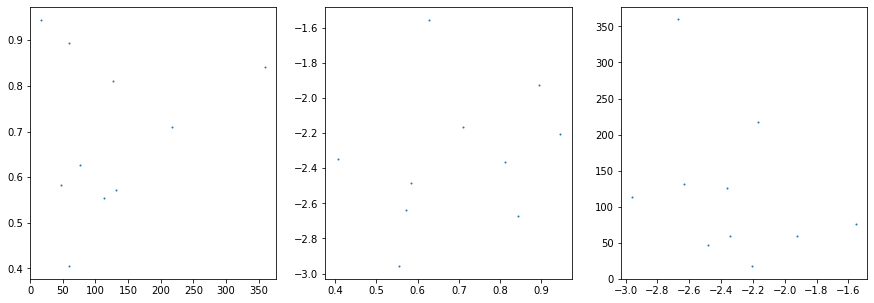

In [90]:
bnum = 70
fig,ax = plt.subplots(ncols=3,figsize=(15,5))
ax[0].scatter(nareas,neccs,s=1)
ax[1].scatter(neccs,ngof,s=1)
ax[2].scatter(ngof,nareas,s=1)

In [91]:
big_inds = np.where(nareas>2000)

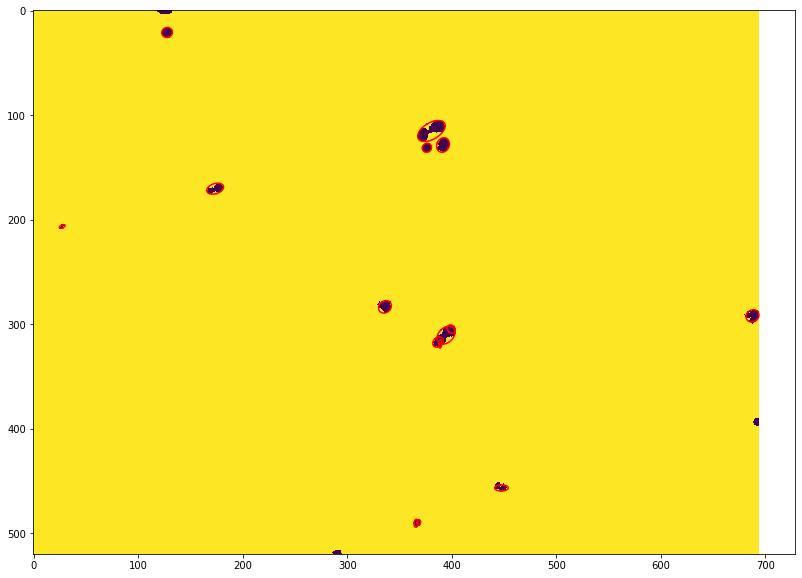

In [92]:
x,y = centers[big_inds].T
ellipses = ellip_coords#[big_inds]
fig = plt.figure(figsize=(20,10))
plt.imshow(255-subset)
#plt.scatter(x,y,c='r',s=1)
for ellipse in ellipses:
    plt.plot(ellipse[0],ellipse[1],c='r')